<a href="https://colab.research.google.com/github/fghadami/DS_personal_projects/blob/main/big_mart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Big Mart Sales Prediction**

In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import reciprocal

from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras
#from scikeras.wrappers import KerasRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
train = pd.read_csv('train.csv')
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


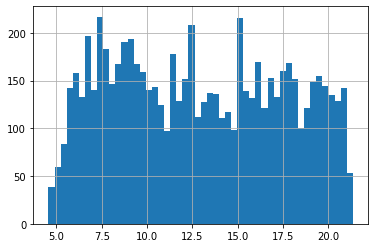

In [ ]:
train['Item_Weight'].hist(bins=50)

In [ ]:
train['Item_Weight'].describe()

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

In [ ]:
train.groupby('Item_Fat_Content')['Item_Weight'].mean()

Item_Fat_Content
LF         12.803212
Low Fat    12.953079
Regular    12.705840
low fat    12.563988
reg        12.842642
Name: Item_Weight, dtype: float64

In [ ]:
train['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

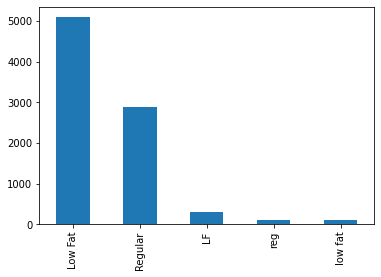

In [ ]:
train['Item_Fat_Content'].value_counts().plot(kind='bar')

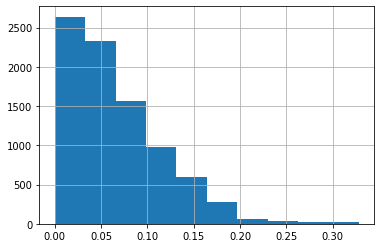

In [ ]:
train['Item_Visibility'].hist(bins=10)

In [ ]:
train['Item_Visibility'].describe()

count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64

In [ ]:
train['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

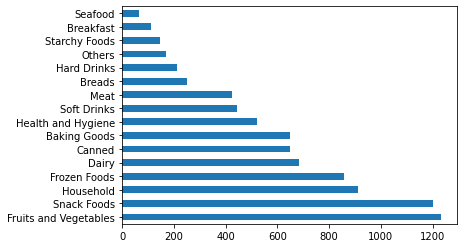

In [ ]:
train['Item_Type'].value_counts().plot(kind='barh')

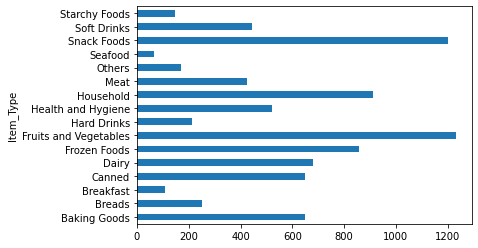

In [ ]:
train.groupby('Item_Type').count()['Item_Identifier'].plot(kind='barh')

In [ ]:
train['Item_MRP'].describe()

count    8523.000000
mean      140.992782
std        62.275067
min        31.290000
25%        93.826500
50%       143.012800
75%       185.643700
max       266.888400
Name: Item_MRP, dtype: float64

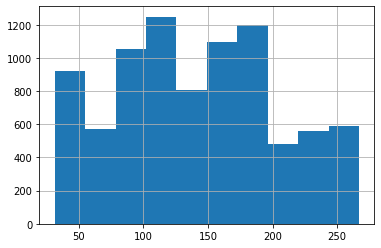

In [ ]:
train['Item_MRP'].hist(bins=10)

In [ ]:
train['Outlet_Identifier'].value_counts()

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

In [ ]:
train['Outlet_Establishment_Year'].value_counts()

1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

In [ ]:
train['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [ ]:
train['Outlet_Size'].isnull().sum()

2410

In [ ]:
#train['Outlet_Size'] = train['Outlet_Size'].fillna(train['Outlet_Size'].mode()[0])

In [ ]:
train['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [ ]:
train['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

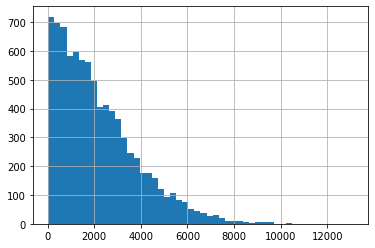

In [ ]:
train['Item_Outlet_Sales'].hist(bins=50)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


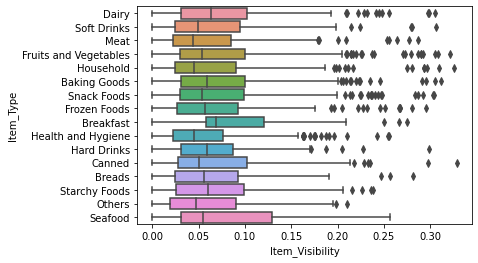

In [ ]:
sns.boxplot(x="Item_Visibility",y='Item_Type', data=train)
plt.show()

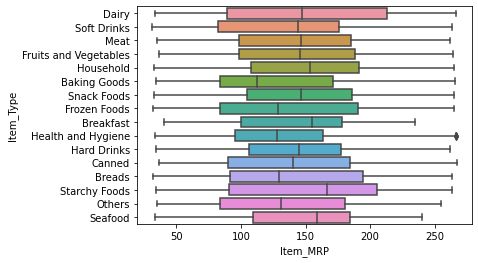

In [ ]:
sns.boxplot(x="Item_MRP",y='Item_Type', data=train)
plt.show()

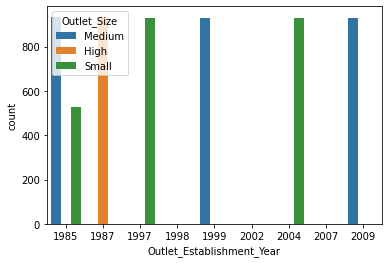

In [ ]:
sns.countplot(x='Outlet_Establishment_Year', hue="Outlet_Size", data=train)
plt.show()

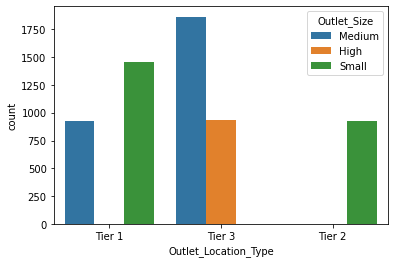

In [ ]:
sns.countplot(x='Outlet_Location_Type', hue="Outlet_Size", data=train)
plt.show()

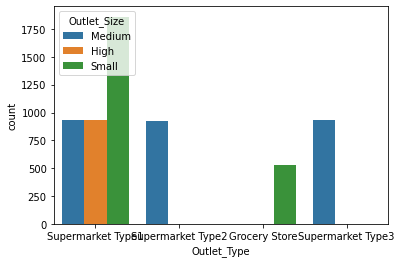

In [ ]:
sns.countplot(x='Outlet_Type', hue="Outlet_Size", data=train)
plt.show()

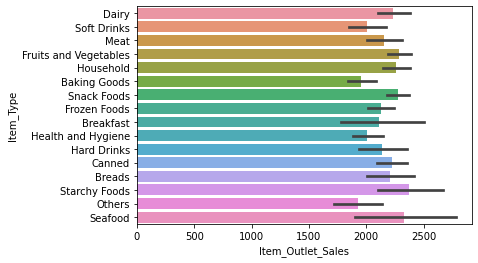

In [ ]:
sns.barplot(y='Item_Type', x='Item_Outlet_Sales', data=train, orient = 'h')
plt.show()

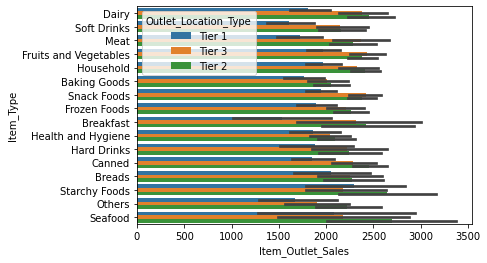

In [ ]:
sns.barplot(y='Item_Type', x='Item_Outlet_Sales', hue= 'Outlet_Location_Type', data=train, orient = 'h')
plt.show()

In [ ]:
corr_train = train.corr()

In [ ]:
corr_train['Item_Outlet_Sales'].sort_values(ascending=False)

Item_Outlet_Sales            1.000000
Item_MRP                     0.567574
Item_Weight                  0.014123
Outlet_Establishment_Year   -0.049135
Item_Visibility             -0.128625
Name: Item_Outlet_Sales, dtype: float64

 **Data Preparation**

In [ ]:
big_mart = train.drop('Item_Outlet_Sales', axis=1)
big_mart_labels = train['Item_Outlet_Sales'].copy()

In [ ]:
type(big_mart_labels)

pandas.core.series.Series

In [ ]:
#train.select_dtypes('number').columns
num_cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP']
big_mart[num_cols].head() 

,Item_Weight,Item_Visibility,Item_MRP
0,9.30,0.016047,249.8092
1,5.92,0.019278,48.2692
2,17.50,0.016760,141.6180
3,19.20,0.000000,182.0950
4,8.93,0.000000,53.8614


In [ ]:
num_pipeline = Pipeline([('num_imputer', SimpleImputer(strategy='median')),
                         ('scale', StandardScaler())])

In [ ]:
num_pipeline.fit_transform(big_mart[num_cols])

array([[-0.83118663, -0.97073217,  1.74745381],
       [-1.63080955, -0.90811123, -1.48902325],
       [ 1.10872696, -0.95691733,  0.01004021],
       ...,
       [-0.52363935, -0.59978449, -0.89720755],
       [-1.32562802,  1.53287976, -0.60797692],
       [ 0.46997492, -0.41193591, -1.05226104]])

In [ ]:
# train.select_dtypes('object')
cat_cols = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
big_mart[cat_cols].head()

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,Low Fat,Dairy,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,DRC01,Regular,Soft Drinks,OUT018,2009,Medium,Tier 3,Supermarket Type2
2,FDN15,Low Fat,Meat,OUT049,1999,Medium,Tier 1,Supermarket Type1
3,FDX07,Regular,Fruits and Vegetables,OUT010,1998,NaN,Tier 3,Grocery Store
4,NCD19,Low Fat,Household,OUT013,1987,High,Tier 3,Supermarket Type1


In [ ]:
cat_pipeline = Pipeline([('cat_imputer', SimpleImputer(strategy='most_frequent')),
                         ('1hot', OneHotEncoder())])

In [ ]:
cat_pipeline.fit_transform(big_mart[['Item_Type','Outlet_Identifier','Outlet_Type']]).todense()

matrix([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 1., 0., 0.]])

In [ ]:
cat_pipeline.named_steps['1hot'].categories_

[array(['Baking Goods', 'Breads', 'Breakfast', 'Canned', 'Dairy',
        'Frozen Foods', 'Fruits and Vegetables', 'Hard Drinks',
        'Health and Hygiene', 'Household', 'Meat', 'Others', 'Seafood',
        'Snack Foods', 'Soft Drinks', 'Starchy Foods'], dtype=object),
 array(['OUT010', 'OUT013', 'OUT017', 'OUT018', 'OUT019', 'OUT027',
        'OUT035', 'OUT045', 'OUT046', 'OUT049'], dtype=object),
 array(['Grocery Store', 'Supermarket Type1', 'Supermarket Type2',
        'Supermarket Type3'], dtype=object)]

In [ ]:
ord_pipeline = Pipeline([('ord_imputer', SimpleImputer(strategy='most_frequent')),
                         ('ord_encoder', OrdinalEncoder())])

In [ ]:
ord_pipeline.fit_transform(big_mart[['Outlet_Establishment_Year','Outlet_Size','Outlet_Location_Type']])

array([[4., 1., 0.],
       [8., 1., 2.],
       [4., 1., 0.],
       ...,
       [6., 2., 1.],
       [8., 1., 2.],
       [2., 2., 0.]])

In [ ]:
ord_pipeline.named_steps['ord_encoder'].categories_

[array([1985, 1987, 1997, 1998, 1999, 2002, 2004, 2007, 2009], dtype=object),
 array(['High', 'Medium', 'Small'], dtype=object),
 array(['Tier 1', 'Tier 2', 'Tier 3'], dtype=object)]

In [ ]:
class Item_Fat_content_Transformer(BaseEstimator,TransformerMixin):
  def __init__(self):
    return None

  def fit(self, X, y=None):
    return self

  def fix_item_fat_content(self, s):
    if s == 'Low Fat': 
      pass
    elif s == 'Regular':
      pass
    elif s == 'low fat':
      s = 'Low Fat'
    elif s == 'reg':
      s = 'Regular'
    elif s == 'LF':
      s = 'Low Fat'
    else:
      s = 'Other'
    return s    
    
  def transform(self, X):
    X.loc[:,'Item_Fat_Content'] = X.loc[:,'Item_Fat_Content'].apply(self.fix_item_fat_content)
    return X

In [ ]:
item_fat_content_pipeline = Pipeline([('fixer', Item_Fat_content_Transformer()),
                                      ('fat_1hot', OneHotEncoder())])

In [ ]:
item_fat_content_pipeline.fit_transform(big_mart[['Item_Fat_Content']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


<8523x2 sparse matrix of type '<class 'numpy.float64'>'
	with 8523 stored elements in Compressed Sparse Row format>

In [ ]:
item_fat_content_pipeline.named_steps['fat_1hot'].categories_

[array(['Low Fat', 'Regular'], dtype=object)]

In [ ]:
preprocessing = ColumnTransformer([('num', num_pipeline, num_cols ),
                                   ('cat', cat_pipeline, ['Item_Type','Outlet_Identifier','Outlet_Type']),
                                   ('ord', ord_pipeline, ['Outlet_Establishment_Year','Outlet_Size', 'Outlet_Location_Type']),
                                   ('ifc', item_fat_content_pipeline, ['Item_Fat_Content'])])

In [ ]:
big_mart_tr = preprocessing.fit_transform(big_mart)

In [ ]:
num_cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP']
cat_encoded_cols = preprocessing.named_transformers_['cat'].named_steps['1hot'].get_feature_names_out(['Item_Type','Outlet_Identifier','Outlet_Type']).tolist()
#ord_encoded_cols = preprocessing.named_transformers_['ord'].named_steps['ord_encoder'].get_feature_names_out(['Outlet_Establishment_Year','Outlet_Size','Outlet_Size'])
ord_cols = ['Outlet_Establishment_Year','Outlet_Size', 'Outlet_Location_Type']
fat_encoded_cols = preprocessing.named_transformers_['ifc'].named_steps['fat_1hot'].get_feature_names_out(['Item_Fat_Content']).tolist()

encoded_cols = num_cols + cat_encoded_cols + ord_cols + fat_encoded_cols

In [ ]:
type(big_mart_tr)

scipy.sparse.csr.csr_matrix

In [ ]:
train_prepared = pd.DataFrame.sparse.from_spmatrix(big_mart_tr, columns=encoded_cols, index=train.index)
train_prepared.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,...,Outlet_Identifier_OUT049,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular
0,-0.831187,-0.970732,1.747454,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0
1,-1.630810,-0.908111,-1.489023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,8.0,1.0,2.0,0.0,1.0
2,1.108727,-0.956917,0.010040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0
3,1.510904,-1.281758,0.660050,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,0.0,1.0
4,-0.918719,-1.281758,-1.399220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0


**Linear Regression**

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(big_mart_tr, big_mart_labels)

LinearRegression()

In [ ]:
big_mart_predictions = lin_reg.predict(big_mart_tr)
lin_mse = mean_squared_error(big_mart_labels, big_mart_predictions)
lin_mse

1270228.568631056

In [ ]:
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1127.0441733273174

In [ ]:
reg_scores = cross_val_score(lin_reg, big_mart_tr, big_mart_labels,
                             scoring='neg_mean_squared_error', cv=10)

In [ ]:
reg_rmse_scores = np.sqrt(-reg_scores)
reg_rmse_scores

array([1165.22779062, 1140.60168563, 1124.65902205, 1117.50932125,
       1121.66764818, 1109.76518434, 1116.64085981, 1140.54402528,
       1139.26730242, 1145.15606669])

In [ ]:
reg_rmse_scores.mean()

1132.1038906265499

In [ ]:
reg_rmse_scores.std()

16.055468577579003

In [ ]:
big_mart_labels.describe()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

**Decision Tree**

In [ ]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(big_mart_tr, big_mart_labels)

DecisionTreeRegressor()

In [ ]:
big_mart_predictions_tree = tree_reg.predict(big_mart_tr)

In [ ]:
tree_mse = mean_squared_error(big_mart_labels, big_mart_predictions_tree)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

4.265840029777195e-15

In [ ]:
scores = cross_val_score(tree_reg, big_mart_tr, big_mart_labels,
                         scoring="neg_mean_squared_error", cv=10)

In [ ]:
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([1516.46395205, 1540.0672982 , 1535.2157276 , 1529.79742004,
       1597.00650943, 1547.08203836, 1497.953963  , 1494.94272892,
       1476.90520423, 1537.53962079])

In [ ]:
tree_rmse_scores.mean()

1527.2974462627935

In [ ]:
tree_rmse_scores.std()

31.862696490833077

**Random Forest**

In [ ]:
forest_reg = RandomForestRegressor()

In [ ]:
forest_scores = cross_val_score(forest_reg, big_mart_tr, big_mart_labels,
                                scoring="neg_mean_squared_error", cv=10)

In [ ]:
forest_rmse_scores = np.sqrt(-forest_scores)
forest_rmse_scores

array([1166.94771352, 1128.85324301, 1168.68740097, 1116.2994505 ,
       1146.29524055, 1102.34576621, 1112.59261111, 1145.61435956,
       1116.19701546, 1158.90502133])

In [ ]:
forest_rmse_scores.mean()

1136.27378222201

In [ ]:
forest_rmse_scores.std()

22.935572296437723

**SVM**

In [ ]:
svm_reg = LinearSVR(epsilon=1.5)

In [ ]:
svm_scores = cross_val_score(svm_reg, big_mart_tr, big_mart_labels,
                             scoring="neg_mean_squared_error", cv=10)

In [ ]:
svm_rmse_scores = np.sqrt(-svm_scores)
svm_rmse_scores

array([1321.94601452, 1317.11856361, 1228.34329024, 1236.70547076,
       1186.14515845, 1266.85182668, 1257.96681198, 1278.24330325,
       1293.79704839, 1275.35392151])

In [ ]:
svm_rmse_scores.mean()

1266.2471409405362

In [ ]:
svm_rmse_scores.std()

39.332905042895035

In [ ]:
svm_poly_reg = SVR(kernel="poly", degree=2, C=150, epsilon=0.1) 

In [ ]:
svm_poly_scores = cross_val_score(svm_poly_reg, big_mart_tr, big_mart_labels,
                             scoring="neg_mean_squared_error", cv=10)

In [ ]:
svm_poly_rmse_scores = np.sqrt(-svm_poly_scores)
svm_poly_rmse_scores

array([1204.24651577, 1207.37028662, 1134.3072857 , 1128.72647352,
       1107.12890154, 1151.64058345, 1148.08023071, 1171.54405053,
       1175.72858462, 1151.33479372])

In [ ]:
svm_poly_rmse_scores.mean()

1158.010770617578

In [ ]:
svm_poly_rmse_scores.std()

30.435719111395766

In [ ]:
svm_rbf_reg = SVR(kernel="rbf", C=150, gamma=0.1, epsilon=0.1) 

In [ ]:
svm_rbf_scores = cross_val_score(svm_rbf_reg, big_mart_tr, big_mart_labels,
                             scoring="neg_mean_squared_error", cv=10)

In [ ]:
svm_rbf_rmse_scores = np.sqrt(-svm_poly_scores)
svm_rbf_rmse_scores

array([1204.24651577, 1207.37028662, 1134.3072857 , 1128.72647352,
       1107.12890154, 1151.64058345, 1148.08023071, 1171.54405053,
       1175.72858462, 1151.33479372])

In [ ]:
svm_rbf_rmse_scores.mean()

1158.010770617578

In [ ]:
svm_rbf_rmse_scores.std()

30.435719111395766

**Neural Net**

In [ ]:
train_prepared.shape

(8523, 38)

In [ ]:
validation_X = train_prepared.sample(frac=0.2, random_state=77)
validation_y = train_prepared.iloc[validation_X.index]
training_X = train_prepared.drop(validation_X.index)
training_y = big_mart_labels.drop(validation_X.index)


In [ ]:
validation_X = np.asarray(validation_X).astype("float32")
validation_y = np.asarray(validation_y).astype("float32")
training_X = np.asarray(training_X).astype("float32")
training_y = np.asarray(training_y).astype("float32")

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(50, input_shape=(38,), activation="relu"))
model.add(keras.layers.Dense(10, activation="relu"))
model.add(keras.layers.Dense(1, activation="linear"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 50)                1950      
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,471
Trainable params: 2,471
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

In [ ]:
model.fit(training_X, training_y, batch_size=32, epochs=50,
          validation_data=(validation_X, validation_y))

Epoch 1/50
214/214 [==============================] - 1s 3ms/step - loss: 1932475.6250 - mean_squared_error: 1932475.6250 - val_loss: 5222329.0000 - val_mean_squared_error: 5222329.0000
Epoch 2/50
214/214 [==============================] - 1s 5ms/step - loss: 1653106.6250 - mean_squared_error: 1653106.6250 - val_loss: 5601173.5000 - val_mean_squared_error: 5601173.5000
Epoch 3/50
214/214 [==============================] - 1s 3ms/step - loss: 1459986.8750 - mean_squared_error: 1459986.8750 - val_loss: 5539819.0000 - val_mean_squared_error: 5539819.0000
Epoch 4/50
214/214 [==============================] - 1s 3ms/step - loss: 1344349.2500 - mean_squared_error: 1344349.2500 - val_loss: 6137173.0000 - val_mean_squared_error: 6137173.0000
Epoch 5/50
214/214 [==============================] - 1s 3ms/step - loss: 1280160.3750 - mean_squared_error: 1280160.3750 - val_loss: 6219674.0000 - val_mean_squared_error: 6219674.0000
Epoch 6/50
214/214 [==============================] - 1s 3ms/step - lo

In [ ]:
_, mse = model.evaluate(training_X, training_y)

214/214 [==============================] - 1s 3ms/step - loss: 1180895.3750 - mean_squared_error: 1176551.3750


In [ ]:
np.sqrt(mse)

1084.6895293124203

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(100, input_shape=(38,), activation="relu"))
model.add(keras.layers.Dense(50, activation="relu"))
model.add(keras.layers.Dense(10, activation="relu"))
model.add(keras.layers.Dense(1, activation="linear"))

In [ ]:
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

In [ ]:
model.fit(training_X, training_y, batch_size=32, epochs=50,
          validation_data=(validation_X, validation_y))

Epoch 1/50
214/214 [==============================] - 2s 6ms/step - loss: 5842427.5000 - mean_squared_error: 5842427.5000 - val_loss: 4854484.0000 - val_mean_squared_error: 4854484.0000
Epoch 2/50
214/214 [==============================] - 1s 4ms/step - loss: 2082589.2500 - mean_squared_error: 2082589.2500 - val_loss: 5133679.5000 - val_mean_squared_error: 5133679.5000
Epoch 3/50
214/214 [==============================] - 1s 3ms/step - loss: 1364524.5000 - mean_squared_error: 1364524.5000 - val_loss: 5805551.0000 - val_mean_squared_error: 5805551.0000
Epoch 4/50
214/214 [==============================] - 1s 3ms/step - loss: 1220006.1250 - mean_squared_error: 1220006.1250 - val_loss: 6192969.5000 - val_mean_squared_error: 6192969.5000
Epoch 5/50
214/214 [==============================] - 1s 3ms/step - loss: 1199353.7500 - mean_squared_error: 1199353.7500 - val_loss: 6446580.5000 - val_mean_squared_error: 6446580.5000
Epoch 6/50
214/214 [==============================] - 1s 4ms/step - lo

In [ ]:
_, mse = model.evaluate(training_X, training_y)

214/214 [==============================] - 1s 2ms/step - loss: 1136086.3750 - mean_squared_error: 1131816.5000


In [ ]:
np.sqrt(mse)

1063.8686479072499

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(100, input_shape=(38,), activation="relu"))
model.add(keras.layers.Dense(50, activation="relu"))
model.add(keras.layers.Dense(10, activation="relu"))
model.add(keras.layers.Dense(1))

In [ ]:
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

In [ ]:
model.fit(training_X, training_y, batch_size=32, epochs=50,
          validation_data=(validation_X, validation_y))

Epoch 1/50
214/214 [==============================] - 3s 4ms/step - loss: 5838692.0000 - mean_squared_error: 5838692.0000 - val_loss: 4714656.0000 - val_mean_squared_error: 4714656.0000
Epoch 2/50
214/214 [==============================] - 1s 3ms/step - loss: 2077170.3750 - mean_squared_error: 2077170.3750 - val_loss: 5591440.5000 - val_mean_squared_error: 5591440.5000
Epoch 3/50
214/214 [==============================] - 1s 3ms/step - loss: 1385548.0000 - mean_squared_error: 1385548.0000 - val_loss: 6339361.0000 - val_mean_squared_error: 6339361.0000
Epoch 4/50
214/214 [==============================] - 1s 3ms/step - loss: 1229184.0000 - mean_squared_error: 1229184.0000 - val_loss: 6266972.0000 - val_mean_squared_error: 6266972.0000
Epoch 5/50
214/214 [==============================] - 1s 3ms/step - loss: 1199984.5000 - mean_squared_error: 1199984.5000 - val_loss: 6060718.5000 - val_mean_squared_error: 6060718.5000
Epoch 6/50
214/214 [==============================] - 1s 3ms/step - lo

In [ ]:
_, mse = model.evaluate(training_X, training_y)

214/214 [==============================] - 1s 3ms/step - loss: 1135542.1250 - mean_squared_error: 1131383.5000


In [ ]:
np.sqrt(mse)

1063.6651258737404

**Gradient Boosting**

In [ ]:
grd_reg = GradientBoostingRegressor(n_estimators=200)
grd_reg.fit(big_mart_tr, big_mart_labels)

GradientBoostingRegressor(n_estimators=200)

In [ ]:
big_mart_predictions = grd_reg.predict(big_mart_tr)
grd_mse = mean_squared_error(big_mart_labels, big_mart_predictions)
grd_mse

1009675.255468977

In [ ]:
grd_rmse = np.sqrt(grd_mse)
grd_rmse

1004.8259826800743

In [ ]:
scores = cross_val_score(grd_reg, big_mart_tr,big_mart_labels,
                         scoring='neg_mean_squared_error', cv=10)
scores

array([-1276708.2218327 , -1210669.85861324, -1230794.63976279,
       -1163723.77659094, -1202537.95514269, -1162360.41373203,
       -1143534.84804289, -1217085.83108957, -1147780.08562172,
       -1250696.05214449])

In [ ]:
grd_rmse_scores = np.sqrt(-scores)
grd_rmse_scores

array([1129.91513922, 1100.30443906, 1109.41184407, 1078.76029617,
       1096.60291589, 1078.12819912, 1069.36188825, 1103.21613072,
       1071.34498908, 1118.34522941])

In [ ]:
grd_rmse_scores.mean()

1095.5391070987346

In [ ]:
grd_rmse_scores.std()

19.57633966336892

**Grid Search**

**1- Regression**
No param to fine tune!

**2- Neural Net**

In [ ]:
def build_model(n_hidden=2, n_neurons=50, learning_rate=3e-3, input_shape=[38]):
  model = keras.models.Sequential()
  model.add(keras.layers.InputLayer(input_shape=input_shape))
  for layer in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation="relu"))
  model.add(keras.layers.Dense(1))
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(loss="mse", optimizer=optimizer)
  return model

In [ ]:
#keras_reg = KerasRegressor(build_model)
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
param_distribs = {"n_hidden":[2,3,5],
                  "n_neurons":np.arange(1,100, step=10),
                  "learning_rate": reciprocal(3e-4, 3e-2)}

In [ ]:
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(training_X,training_y, epochs=100,
                  validation_data=(validation_X, validation_y))

Streaming output truncated to the last 5000 lines.
143/143 [==============================] - 0s 3ms/step - loss: 7738790.5000 - val_loss: 2.0167
Epoch 14/100
143/143 [==============================] - 0s 3ms/step - loss: 7738330.0000 - val_loss: 2.2627
Epoch 15/100
143/143 [==============================] - 0s 3ms/step - loss: 7737862.0000 - val_loss: 2.5315
Epoch 16/100
143/143 [==============================] - 0s 3ms/step - loss: 7737399.0000 - val_loss: 2.8223
Epoch 17/100
143/143 [==============================] - 0s 3ms/step - loss: 7736932.0000 - val_loss: 3.1361
Epoch 18/100
143/143 [==============================] - 0s 3ms/step - loss: 7736470.5000 - val_loss: 3.4705
Epoch 19/100
143/143 [==============================] - 1s 4ms/step - loss: 7736008.5000 - val_loss: 3.8286
Epoch 20/100
143/143 [==============================] - 0s 3ms/step - loss: 7735541.5000 - val_loss: 4.2122
Epoch 21/100
143/143 [==============================] - 1s 4ms/step - loss: 7735080.0000 - val_los

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f5b4f8fc190>,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5b4fa21210>,
                                        'n_hidden': [2, 3, 5],
                                        'n_neurons': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])})

In [ ]:
type(big_mart_tr)

scipy.sparse.csr.csr_matrix

In [ ]:
rnd_search_cv.best_params_

{'learning_rate': 0.004905163764198674, 'n_hidden': 2, 'n_neurons': 11}

In [ ]:
rnd_search_cv.best_score_

-1176076.6666666667

In [ ]:
model = rnd_search_cv.best_estimator_.model

In [ ]:
np.sqrt(-rnd_search_cv.best_score_)

1084.4706850195014